## Develop AI agents using Q-Learning, Minimax and Alpha Beta Pruning for Tic-Tac-Toe

In [18]:
!pip install pygame

In [1]:
import pygame
import sys
import random
import time
import numpy as np
import pickle
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

pygame 2.6.0 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Set Hyperparameters

In [2]:
# Game variables
ROWS, COLS = 3, 3
BOARD_SIZE = 3

DRAW = 'draw'

# parameters for minimax
MIN_VALUE = -1000
MAX_VALUE = 1000
scores = {'O':-1, 'X':1, DRAW:0}

# q-learning reward parameters
REWARD_WIN = 1
REWARD_LOSE = -1
REWARD_MOVE = 0

### Define the Game Board

In [6]:
class TicTacToeBoard:
    
    def __init__(self, current_player="X"):
        self.board = np.full((ROWS, COLS), '', dtype=object)
        self.current_player = current_player

    def check_winner(self,):
        # Check rows
        for row in self.board:
            if row[0] == row[1] == row[2] and row[0] != '':
                return row[0]  # Return 'X' or 'O'
    
        # Check columns
        for col in range(COLS):
            if self.board[0][col] == self.board[1][col] == self.board[2][col] and self.board[0][col] != '':
                return self.board[0][col]

        # Check diagonals
        if self.board[0][0] == self.board[1][1] == self.board[2][2] and self.board[0][0] != '':
            return self.board[0][0]
        if self.board[0][2] == self.board[1][1] == self.board[2][0] and self.board[0][2] != '':
            return self.board[0][2]

        if self.board_full():
            return DRAW
            
        return None  # No winner
    
    def board_full(self,):
        return all(cell != '' for row in self.board for cell in row)

    def board_empty(self,):
        return all(cell == '' for row in self.board for cell in row)

    def cell_available(self, cell_row, cell_col):
        return self.board[cell_row][cell_col] == ""
        
    def add_move(self, cell_row, cell_col):
        self.board[cell_row][cell_col] = self.current_player
        self.current_player = "O" if self.current_player == "X" else "X"

    def cancel_move(self, cell_row, cell_col, player):
        self.board[cell_row][cell_col] = ''  # Clear the cell
        self.current_player = player  # Switch back to the previous player
    
    def add_move_randomly(self):
        empty_positions = [(i, j) for i in range(ROWS) for j in range(COLS) if self.board[i][j] == '']

        # Randomly choose one of the empty positions
        chosen_position = random.choice(empty_positions)
        self.add_move(chosen_position[0], chosen_position[1])

    def add_move_minimax(self, minimax_method, is_alpha_beta_pruning, is_mini):
        if self.board_empty():
            self.add_move_randomly()
        else:
            best_move = minimax_method.best_move(is_alpha_beta_pruning, is_mini)
            self.add_move(best_move[0], best_move[1])

    def add_move_q(self, agent_x, agent_o):
        if self.current_player == 'X':
            best_move = agent_x.greedy_choose(self.board)
            self.add_move(best_move[0], best_move[1])
        elif self.current_player == 'O':
            best_move = agent_o.greedy_choose(self.board)
            self.add_move(best_move[0], best_move[1])

    def add_move_agent(self, minimax_method, game, q_agent_x, q_agent_o):
        if game.is_random():
            self.add_move_randomly()
        elif game.is_qlearning():
            self.add_move_q(q_agent_x, q_agent_o)
        else:
            self.add_move_minimax(minimax_method, game.is_alpha_beta_pruning(), True)

    def print_board(self):
        for row in self.board:
            print(" | ".join(cell if cell else " " for cell in row))
            print("-" * (len(row) * 4 - 3))
    
    def reset_game(self):
        self.__init__()


### Implementation of Q learning Algorithms and Train the Q agents

In [11]:
class QLearningAgent:
    def __init__(self, player, episodes=0):
        # Initialize the Q-learning agent for a specific player ('X' or 'O').
        self.player = player
        self.episodes = episodes
        self.q_table = {} if episodes <= 0 else load_q_table(episodes, player) # State -> Q-values (3x3 array)
        self.epsilon = 0.1  # Exploration rate
        self.alpha = 0.1    # Learning rate
        self.gamma = 0.9    # Discount factor

    def get_q_values(self, state):
        # Retrieve the Q-values for a given state from the Q-table.
        return self.q_table.get(self.state_to_string(state), np.zeros((ROWS, COLS)))

    def state_to_string(self, state):
        # Convert the state (3x3 board) to a string for use as a key in the Q-table.
        return ''.join(['E' if cell == '' else cell for cell in state.flatten()])

    def available_actions(self, state):
        # Return a list of available (empty) actions (positions) for the current state.
        return [(i, j) for i in range(ROWS) for j in range(COLS) if state[i][j] == '']

    def choose_action(self, state):
        # Choose an action using the epsilon-greedy strategy.
        if random.random() < self.epsilon:
            return random.choice(self.available_actions(state))  # Explore
        else:
            return self.greedy_choose(state)

    def greedy_choose(self, state):
        # Choose a best action according to the max q_value.
        q_values = self.get_q_values(state)
        max_q_value = q_values.max()
        max_actions = [(i, j) for i in range(ROWS) for j in range(COLS) if q_values[i][j] == max_q_value and state[i][j] == '']
            
        return random.choice(max_actions) if max_actions else random.choice(self.available_actions(state))

    def update_q_value(self, state, action, reward, next_state):
        # Update the Q-values based on the received reward.
        current_q_values = self.get_q_values(state)
        next_q_values = self.get_q_values(next_state)

        # Use the Q-learning formula to update the Q-value for the taken action
        current_q_values[action[0], action[1]] += self.alpha * (reward + self.gamma * next_q_values.max() - current_q_values[action[0], action[1]])
        # Store the updated Q-values back into the Q-table
        self.q_table[self.state_to_string(state)] = current_q_values

def dump_q_table(q_table, episodes, agent):
    with open(f'qtable_{episodes}_{agent}.pkl', 'wb') as file:
        pickle.dump(q_table, file)

def load_q_table(episodes, agent):
    file_name = f'qtable_{episodes}_{agent}.pkl'
    if not os.path.exists(file_name):
        return {}
    with open(file_name, 'rb') as file:
        print(f'Loaded Q-table: {file_name}')
        return pickle.load(file)

def play_agent(player, oppenent, board):
    action = player.choose_action(state)
    board.add_move(action_x[0], action_x[1])  # Make the move
    next_state = board.board.copy()

    # Check for a winner or draw
    winner = board.check_winner()
    if winner == 'X':
        reward_x = 1  # Win for X
        reward_o = -1  # Punish O for losing
        game_over = True
    elif winner == DRAW:
        reward_x = 0.5  # Draw
        reward_o = 0.5
        game_over = True
    else:
        reward_x = 0  # No reward for continuing play
        reward_o = 0
    
    # Update Q-value for Agent X
    agent_x.update_q_value(state, action_x, reward_x, next_state)
    if last_state is not None and last_action is not None:
        agent_o.update_q_value(last_state, last_action, reward_o, state)
    last_state = state
    last_action = action_x
    state = next_state  # Move to the next state
            
def train_q_learning_agents(episodes, base_episodes):
    agent_x = QLearningAgent('X', base_episodes)
    agent_o = QLearningAgent('O', base_episodes)

    for episode in tqdm(range(episodes - base_episodes), desc=f"Training {episodes} episodes"):
        board = TicTacToeBoard()  # Reset the board
        last_state = None
        last_action = None
        state = board.board.copy()
        game_over = False

        current_agent = agent_x
        opponent_agent = agent_o

        while not game_over:
            action = current_agent.choose_action(state)
            board.add_move(action[0], action[1])  # Make the move
            next_state = board.board.copy()

            # Check for a winner or draw
            winner = board.check_winner()
            if winner == current_agent.player:
                reward_current = 1  # Win for X
                reward_opponent = -1  # Punish O for losing
                game_over = True
            elif winner == DRAW:
                reward_current = 0.5  # Draw
                reward_opponent = 0.5
                game_over = True
            else:
                reward_current = 0  # No reward for continuing play
                reward_opponent = 0
            
            # Update Q-value for Agent X
            current_agent.update_q_value(state, action, reward_current, next_state)
            if last_state is not None and last_action is not None:
                opponent_agent.update_q_value(last_state, last_action, reward_opponent, state)
            last_state = state
            last_action = action
            state = next_state  # Move to the next state
            current_agent = agent_x if current_agent.player == 'O' else agent_o
            opponent_agent = agent_o if opponent_agent.player == 'X' else agent_x
    
    dump_q_table(agent_x.q_table, episodes, 'X')
    dump_q_table(agent_o.q_table, episodes, 'O')
    return agent_x, agent_o


#### Training Q-Learning Agents from 2000 Episodes to 300000 Episodes to Evaluate the Effect of Performance Caused by Episode Parameter

In [167]:
train_q_learning_agents(2000, 0)  # Train the agents for 2000 episodes
train_q_learning_agents(5000, 0)  # Train the agents for 5000 episodes
train_q_learning_agents(8000, 0)  # Train the agents for 8000 episodes
train_q_learning_agents(10000, 0)  # Train the agents for 10000 episodes
train_q_learning_agents(12000, 0)  # Train the agents for 12000 episodes
train_q_learning_agents(15000, 0)  # Train the agents for 15000 episodes
train_q_learning_agents(18000, 0)  # Train the agents for 18000 episodes

Training 18000 episodes: 100%|█████████████████████████████████████████████████| 18000/18000 [00:05<00:00, 3043.89it/s]


(<__main__.QLearningAgent at 0x13ee83a6210>,
 <__main__.QLearningAgent at 0x13eec2a3bc0>)

In [169]:
train_q_learning_agents(20000, 0)  # Train the agents for 20000 episodes
train_q_learning_agents(50000, 0)  # Train the agents for 50000 episodes
train_q_learning_agents(100000, 0)  # Train the agents for 100000 episodes
train_q_learning_agents(200000, 0)  # Train the agents for 200000 episodes
train_q_learning_agents(300000, 0)  # Train the agents for 300000 episodes

Training 300000 episodes: 100%|██████████████████████████████████████████████| 300000/300000 [01:46<00:00, 2817.44it/s]


(<__main__.QLearningAgent at 0x13ee8385d90>,
 <__main__.QLearningAgent at 0x13eec1879e0>)

### Implementation of Minimax and Alpha Beta Pruning Algorithms

In [13]:
class Minimax:
    
    def __init__(self, board, game):
        self.board = board
        self.game = game

    # Minimax Algorithm
    def minimax(self, depth, is_mini, row_, col_):
        winner = self.board.check_winner()
        if winner is not None:  # If there is a winner
            return scores[winner]

        if self.game.is_limit_depth() and depth >= self.game.depth:  # Limit recursion depth
            return 0
        
        player = self.board.current_player
        if is_mini:  # O's turn
            best_score = MAX_VALUE
            for row in range(3):
                for col in range(3):
                    if self.board.cell_available(row, col):
                        self.board.add_move(row, col)
                        score = self.minimax(depth + 1, False, row, col)
                        self.board.cancel_move(row, col, player)  # Undo move
                        best_score = min(best_score, score)
            return best_score
        else:  # X's turn
            best_score = MIN_VALUE
            for row in range(3):
                for col in range(3):
                    if self.board.cell_available(row, col):
                        self.board.add_move(row, col)
                        score = self.minimax(depth + 1, True, row, col)
                        self.board.cancel_move(row, col, player)  # Undo move
                        best_score = max(best_score, score)
            return best_score

    # Minimax and alpha beta pruning algorithm
    def minimax_alpha_beta_pruning(self, depth, is_mini, row_, col_, alpha, beta):
        winner = self.board.check_winner()
        if winner is not None:  # If there is a winner
            return scores[winner]
    
        if self.game.is_limit_depth() and depth >= self.game.depth:  # Limit recursion depth
            return 0

        player = self.board.current_player
        if is_mini:  # O's turn
            best_score = MAX_VALUE
            for row in range(3):
                for col in range(3):
                    if self.board.cell_available(row, col):
                        self.board.add_move(row, col)
                        score = self.minimax_alpha_beta_pruning(depth + 1, False, row, col, alpha, beta)
                        self.board.cancel_move(row, col, player)  # Undo move
                        best_score = min(best_score, score)
                        beta = min(beta, best_score)
                        if beta <= alpha:
                            break  # Alpha-beta pruning
            return best_score
        else:  # X's turn
            best_score = MIN_VALUE
            for row in range(3):
                for col in range(3):
                    if self.board.cell_available(row, col):
                        self.board.add_move(row, col)
                        score = self.minimax_alpha_beta_pruning(depth + 1, True, row, col, alpha, beta)
                        self.board.cancel_move(row, col, player)  # Undo move
                        best_score = max(best_score, score)
                        alpha = max(alpha, best_score)
                        if beta <= alpha:
                            break  # Alpha-beta pruning
            return best_score


    # decide the next best move
    def best_move(self, is_alpha_beta_pruning, is_mini):
        best_value = MAX_VALUE if is_mini else MIN_VALUE # Start with the lowest value
        best_move = (-1, -1)

        alpha = MIN_VALUE
        beta = MAX_VALUE

        player = self.board.current_player
        for row in range(ROWS):
            for col in range(COLS):
                if self.board.cell_available(row, col):
                    self.board.add_move(row, col)
                    move_value = self.minimax_alpha_beta_pruning(0, not(is_mini), row, col, alpha, beta) if is_alpha_beta_pruning else self.minimax(0, not(is_mini), row, col) # Evaluate move
                    self.board.cancel_move(row, col, player)  # Undo move
                    if is_mini:
                        if move_value < best_value:  # Minimizing for 'O'
                            best_move = (row, col)
                            best_value = move_value
                    else:
                        if move_value > best_value:  # Maximizing for 'O'
                            best_move = (row, col)
                            best_value = move_value
        return best_move
        

### Define the Game Entity, Storing Game Configuration (Game Mode and Parameters)

In [15]:
game_modes = ['qlearning', 'minimax', 'alpha_beta_pruning', 'random']

class Game:
    
    def __init__(self, board, depth, game_mode=0, limit_depth = False):
        self.game_mode = game_mode
        self.game_over = False
        self.game_winner = None
        self.limit_depth = limit_depth
        self.depth = depth
        self.board = board

    def switch_mode(self, mode):
        self.game_mode = mode

    def next_mode(self):
        self.game_mode = 0 if self.game_mode == 3 else self.game_mode + 1

    def current_mode(self):
        return game_modes[self.game_mode]

    def max_depth(self):
        return self.depth

    def set_winner(self, winner):
        self.game_over = True
        self.game_winner = winner

    def set_depth(depth):
        self.depth = depth

    def is_minimax(self):
        return self.game_mode == 1

    def is_alpha_beta_pruning(self):
        return self.game_mode == 2

    def is_random(self):
        return self.game_mode == 3

    def is_limit_depth(self):
        return self.limit_depth

    def is_qlearning(self):
        return self.game_mode == 0
    
    def reset_game(self):
        board.reset_game()
        self.game_over = False
        self.game_winner = None

### Game Application

#### Draw game graphic user interface for playing, Run This Cell to Play

In [19]:
# Initialize Pygame
pygame.init()
board = TicTacToeBoard()
game = Game(board, 0, 0, False)
minimax_method = Minimax(board, game)
q_agent_x = QLearningAgent('X', 100000)
q_agent_o = QLearningAgent('O', 100000)

# Set up display
width, height = 900, 630
board_width = 630
option_width = 270
screen = pygame.display.set_mode((width, height))
pygame.display.set_caption("Tic Tac Toe")
button_hover = False

# Colors
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GRAY = (128,128,128)
RED = (255, 0, 0)
BLUE = (0, 0, 255)
GREEN = (0, 255, 0)
COVER = (110,146,196)
BUTTON_COLOR = (0, 128, 255)
BUTTON_HOVER_COLOR = (0, 100, 200)
BUTTON_FONT_COLOR = (255, 255, 255)

button_rect = pygame.Rect(board_width + 100, 500, 100, 30)
option_rect = pygame.Rect(board_width + 50, 100, 200, 30)
winner_rect = pygame.Rect(board_width + 50, 450, 200, 30)
font = pygame.font.Font(None, 36)
option_font = pygame.font.Font(None, 24)

def draw_board():
    game_board = board.board
    for row in range(ROWS):
        for col in range(COLS):
            color = WHITE
            pygame.draw.rect(screen, color, (col * (board_width // 3), row * (height // 3), board_width // 3, height // 3), 0)

            # Draw X or O in the small board
            if game_board[row][col] == "X":
                pygame.draw.line(screen, RED, (col * (board_width // 3), row * (height // 3)),
                                 ((col + 1) * (board_width // 3), (row + 1) * (height // 3)), 5)
                pygame.draw.line(screen, RED, ((col + 1) * (board_width // 3), row * (height // 3)),
                                 (col * (board_width // 3), (row + 1) * (height // 3)), 5)
            elif game_board[row][col] == "O":
                pygame.draw.circle(screen, BLUE, 
                                   (col * (board_width // 3) + (board_width // 6), 
                                    row * (height // 3) + (height // 6)), 
                                   (board_width // 6 - 30), 5)
    # Draw grid lines for the board
    for i in range(1, BOARD_SIZE):
        pygame.draw.line(screen, BLACK, (i * board_width // 3, 0), (i * board_width // 3, height), 3)
        pygame.draw.line(screen, BLACK, (0, i * height // 3), (board_width, i * height // 3), 3)

def draw_options():
    option_color = BUTTON_HOVER_COLOR if button_hover else BUTTON_COLOR
    pygame.draw.rect(screen, BUTTON_COLOR, option_rect)
    text = 'change agent'
    text_surface = option_font.render(text, True, BUTTON_FONT_COLOR)
    text_rect = text_surface.get_rect(center=option_rect.center)
    screen.blit(text_surface, text_rect)

    agent_texts = ['current agent:', game.current_mode()]
    if game.is_minimax() or game.is_alpha_beta_pruning():
        agent_texts += ['depth limit:', str(game.max_depth()) if game.is_limit_depth() else 'No Limit']
    for i, agent_text in enumerate(agent_texts):
        agent_surface = option_font.render(agent_text, True, BLACK if i % 2 == 1 else GRAY)
        screen.blit(agent_surface, (board_width + 50, i*20 + 20))
    

def draw_reset():
    """Draw a button on the screen."""
    button_color = BUTTON_HOVER_COLOR if button_hover else BUTTON_COLOR
    pygame.draw.rect(screen, BUTTON_COLOR, button_rect)
    # Render the text
    text_surface = font.render('Reset', True, BUTTON_FONT_COLOR)
    text_rect = text_surface.get_rect(center=button_rect.center)
    screen.blit(text_surface, text_rect)

def draw_winner():
    game_winner = game.game_winner
    if game_winner == None:
        return
    """Draw a pop-up text message on the screen."""
    text = ''
    if game_winner == DRAW:
        text = 'DRAW!'
    else:
        text = 'AI WINS!' if game_winner == 'O' else 'Human WINS!'
    text_surface = font.render(text, True, RED)
    text_rect = text_surface.get_rect(center=winner_rect.center)
    
    # Draw a background for the text
    popup_rect = pygame.Rect(text_rect.x - 10, text_rect.y - 10, text_rect.width + 20, text_rect.height + 20)
    pygame.draw.rect(screen, GRAY, popup_rect)  # Light gray background
    pygame.draw.rect(screen, BLACK, popup_rect, 2)      # Black border
    screen.blit(text_surface, text_rect)

# Main loop
running = True
while running:
    screen.fill(WHITE)
    draw_board()
    draw_reset()
    draw_winner()
    draw_options()

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        elif event.type == pygame.MOUSEBUTTONDOWN:
            if button_rect.collidepoint(event.pos):
                game.reset_game()
                break
            if option_rect.collidepoint(event.pos):
                game.next_mode()
            if game.game_over:
                break
            mouse_x, mouse_y = event.pos
            
            # Determine which board and cell to place the mark
            cell_col = mouse_x // (board_width // 3)
            cell_row = mouse_y // (height // 3)
            if cell_col < COLS and cell_row < ROWS and board.cell_available(cell_row, cell_col):
                board.add_move(cell_row, cell_col)
                winner = board.check_winner()
                if winner:
                    game.set_winner(winner)
                else:
                    board.add_move_agent(minimax_method, game, q_agent_x, q_agent_o)
                    winner = board.check_winner()
                    if winner:
                        game.set_winner(winner)

    pygame.display.flip()

# Quit Pygame
pygame.quit()
sys.exit()


Loaded Q-table: qtable_100000_X.pkl
Loaded Q-table: qtable_100000_O.pkl


SystemExit: 

D:\anaconda\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Evaluation

#### Qlearning Agent Plays with Different Episodes against Random Agent

In [22]:
board = TicTacToeBoard()
game = Game(board, 0, 0, False)
q_agent_xs = [QLearningAgent('X', 2000), QLearningAgent('X', 5000),
              QLearningAgent('X', 8000), QLearningAgent('X', 10000), 
              QLearningAgent('X', 12000), QLearningAgent('X', 15000), QLearningAgent('X', 18000),
              QLearningAgent('X', 20000), QLearningAgent('X', 50000), 
              QLearningAgent('X', 100000), QLearningAgent('X', 200000),
              QLearningAgent('X', 300000)]

q_agent_os = [QLearningAgent('O', 2000), QLearningAgent('O', 5000),
              QLearningAgent('O', 8000), QLearningAgent('O', 10000),
              QLearningAgent('O', 12000), QLearningAgent('O', 15000), QLearningAgent('O', 18000),
              QLearningAgent('O', 20000), QLearningAgent('O', 50000), 
              QLearningAgent('O', 100000), QLearningAgent('O', 200000),
              QLearningAgent('O', 300000)]

Loaded Q-table: qtable_2000_X.pkl
Loaded Q-table: qtable_5000_X.pkl
Loaded Q-table: qtable_8000_X.pkl
Loaded Q-table: qtable_10000_X.pkl
Loaded Q-table: qtable_12000_X.pkl
Loaded Q-table: qtable_15000_X.pkl
Loaded Q-table: qtable_18000_X.pkl
Loaded Q-table: qtable_20000_X.pkl
Loaded Q-table: qtable_50000_X.pkl
Loaded Q-table: qtable_100000_X.pkl
Loaded Q-table: qtable_200000_X.pkl
Loaded Q-table: qtable_300000_X.pkl
Loaded Q-table: qtable_2000_O.pkl
Loaded Q-table: qtable_5000_O.pkl
Loaded Q-table: qtable_8000_O.pkl
Loaded Q-table: qtable_10000_O.pkl
Loaded Q-table: qtable_12000_O.pkl
Loaded Q-table: qtable_15000_O.pkl
Loaded Q-table: qtable_18000_O.pkl
Loaded Q-table: qtable_20000_O.pkl
Loaded Q-table: qtable_50000_O.pkl
Loaded Q-table: qtable_100000_O.pkl
Loaded Q-table: qtable_200000_O.pkl
Loaded Q-table: qtable_300000_O.pkl


##### Q learning is X, random agent is O

test result: win times of 2000 episodes q-learning agent and random agent are 68 : 18, the time is 0.010938882827758789s
test result: win times of 5000 episodes q-learning agent and random agent are 81 : 11, the time is 0.010170936584472656s
test result: win times of 8000 episodes q-learning agent and random agent are 82 : 7, the time is 0.010845661163330078s
test result: win times of 10000 episodes q-learning agent and random agent are 85 : 6, the time is 0.009908914566040039s
test result: win times of 12000 episodes q-learning agent and random agent are 86 : 4, the time is 0.00984954833984375s
test result: win times of 15000 episodes q-learning agent and random agent are 90 : 3, the time is 0.01300048828125s
test result: win times of 18000 episodes q-learning agent and random agent are 89 : 2, the time is 0.011672496795654297s
test result: win times of 20000 episodes q-learning agent and random agent are 84 : 3, the time is 0.01028299331665039s
test result: win times of 50000 episode

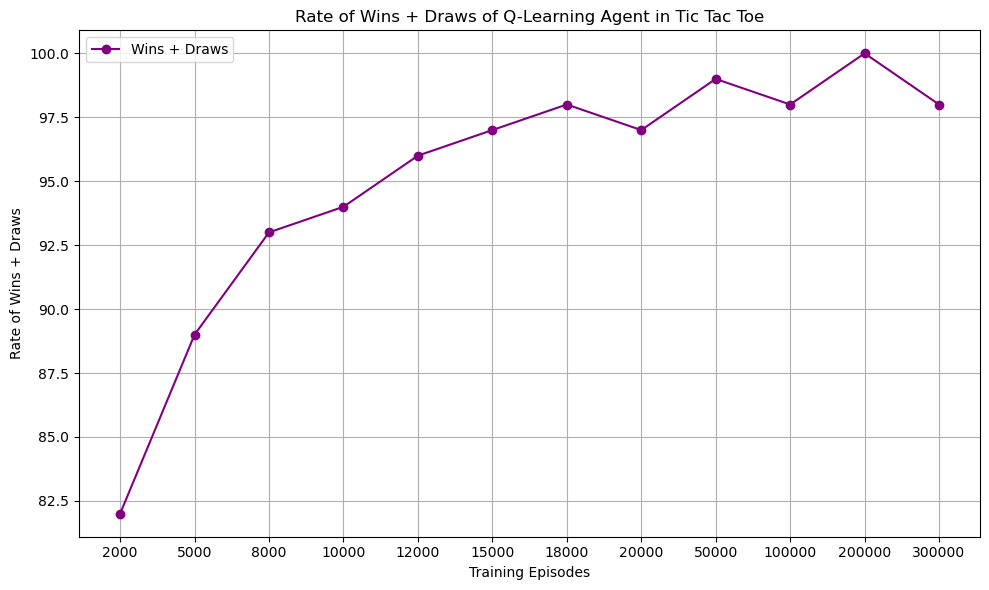

In [173]:
rst_x_random = {}
for q_agent_x in q_agent_xs:
    X_win = 0
    O_win = 0
    draws = 0
    
    start_time = time.time()
    
    for i in range(100):
        winner = None
        X_play = True
        while not winner:
            if X_play:
                board.add_move_q(q_agent_x, q_agent_o)
                winner = board.check_winner()
                X_play = False
                if winner:
                    break
            else:
                board.add_move_randomly()
                winner = board.check_winner()
                X_play = True
                if winner:
                    break
        
        if winner == 'X':
            X_win = X_win + 1
        elif winner == 'O':
            O_win = O_win + 1
        else:
            draws = draws + 1
        game.reset_game()

    end_time = time.time()

    rst_x_random[q_agent_x.episodes] = [X_win, O_win, draws]
    print(f'test result: win times of {q_agent_x.episodes} episodes q-learning agent and random agent are {X_win} : {O_win}, the time is {end_time-start_time}s')

def plot_result(rst_map):
    # Prepare data for plotting
    episodes = list(rst_map.keys())
    results = list(rst_map.values())
    
    # Calculate wins + draws
    win_draws = [result[0] + result[2] for result in results]
    
    # Create a custom x-axis for uniform spacing
    x_positions = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]  # Custom x positions
    
    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.plot(x_positions, win_draws, marker='o', label='Wins + Draws', color='purple')
    
    # Setting custom ticks for the x-axis
    plt.xticks(x_positions, episodes)
    
    # Adding titles and labels
    plt.title('Rate of Wins + Draws of Q-Learning Agent in Tic Tac Toe')
    plt.xlabel('Training Episodes')
    plt.ylabel('Rate of Wins + Draws')
    plt.grid()
    
    # Show plot
    plt.tight_layout()
    plt.legend()
    plt.show()

plot_result(rst_x_random)

##### Q learning is O, random agent is X

mock result: win times of 300000 episodes q-learning O agent and random agent are 37 : 45, the time is 0.01008296012878418s
mock result: win times of 300000 episodes q-learning O agent and random agent are 44 : 30, the time is 0.011811971664428711s
mock result: win times of 300000 episodes q-learning O agent and random agent are 64 : 14, the time is 0.010868549346923828s
mock result: win times of 300000 episodes q-learning O agent and random agent are 61 : 12, the time is 0.010772705078125s
mock result: win times of 300000 episodes q-learning O agent and random agent are 59 : 13, the time is 0.015223503112792969s
mock result: win times of 300000 episodes q-learning O agent and random agent are 70 : 13, the time is 0.039243221282958984s
mock result: win times of 300000 episodes q-learning O agent and random agent are 66 : 14, the time is 0.000997304916381836s
mock result: win times of 300000 episodes q-learning O agent and random agent are 70 : 10, the time is 0.0156557559967041s
mock r

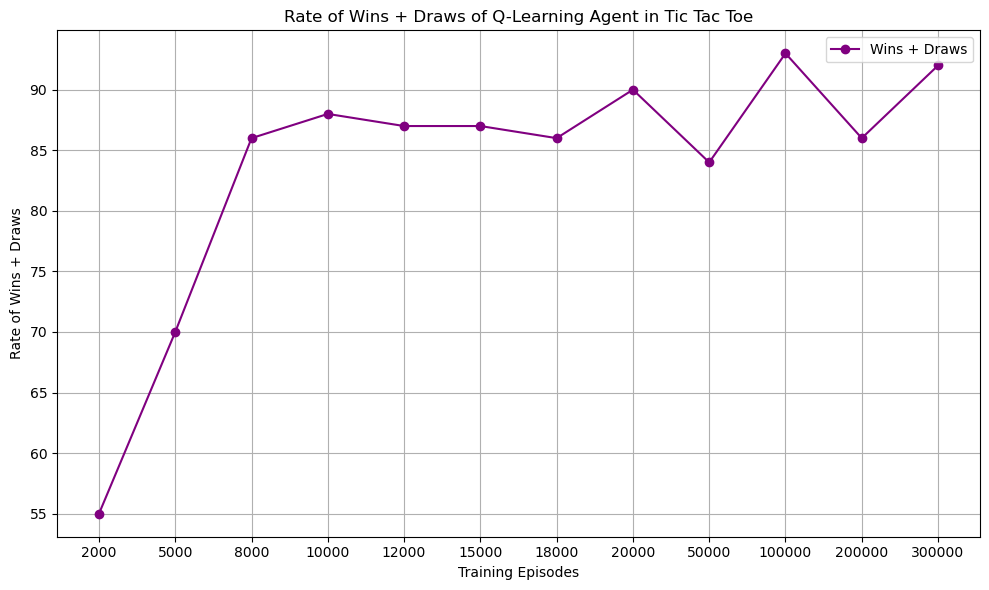

In [179]:
rst_o_random = {}

for q_agent_o in q_agent_os:
    X_win = 0
    O_win = 0
    draws = 0
    
    start_time = time.time()
    
    for i in range(100):
        winner = None
        X_play = True
        while not winner:
            if X_play:
                board.add_move_randomly()
                winner = board.check_winner()
                X_play = False
                if winner:
                    break
            else:
                board.add_move_q(q_agent_x, q_agent_o)
                winner = board.check_winner()
                X_play = True
                if winner:
                    break
        
        if winner == 'X':
            X_win = X_win + 1
        elif winner == 'O':
            O_win = O_win + 1
        else:
            draws = draws + 1
        game.reset_game()

    end_time = time.time()
    rst_o_random[q_agent_o.episodes] = [O_win, X_win, draws]

    print(f'mock result: win times of {q_agent_x.episodes} episodes q-learning O agent and random agent are {O_win} : {X_win}, the time is {end_time-start_time}s')

plot_result(rst_o_random)

#### Minimax Agent with Different Depth plays against q learning agent

In [26]:
board = TicTacToeBoard()

depths = [2, 4, 6, 8, 10]
games = [Game(board, depth, 1, True) for depth in depths]
games.append(Game(board, 0, 1, False))

minimax_method = Minimax(board, game)

q_agent_x = QLearningAgent('X', 100000)
q_agent_o = QLearningAgent('O', 100000)

Loaded Q-table: qtable_100000_X.pkl
Loaded Q-table: qtable_100000_O.pkl


##### Minimax is X, Q-learning is O

test result: win times of minimax agent 2 depth against 100000 episodes q-learning agent are 84 : 0, the time is 5.753747940063477s
test result: win times of minimax agent 4 depth against 100000 episodes q-learning agent are 72 : 0, the time is 6.035160779953003s
test result: win times of minimax agent 6 depth against 100000 episodes q-learning agent are 72 : 0, the time is 5.732841730117798s
test result: win times of minimax agent 8 depth against 100000 episodes q-learning agent are 79 : 0, the time is 6.7729105949401855s
test result: win times of minimax agent 10 depth against 100000 episodes q-learning agent are 72 : 0, the time is 5.667339086532593s
test result: win times of minimax agent no limit depth against 100000 episodes q-learning agent are 77 : 0, the time is 5.976936340332031s


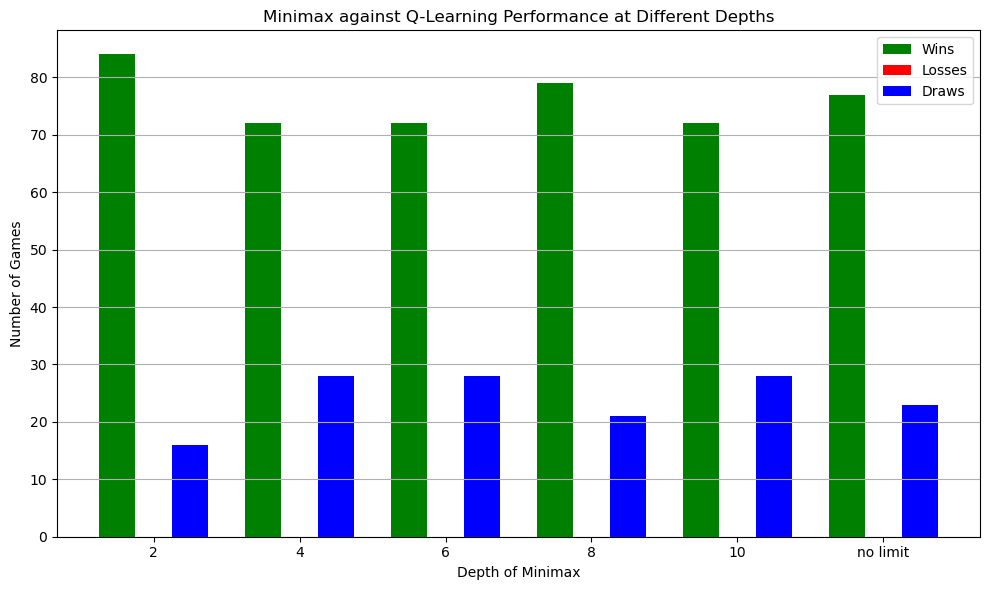

In [38]:
rst_mini_x = {}
for game in games:
    X_win = 0
    O_win = 0
    draws = 0
    
    start_time = time.time()
    
    for i in range(100):
        winner = None
        X_play = True
        while not winner:
            if X_play:
                board.add_move_minimax(minimax_method, game.is_alpha_beta_pruning(), False)
                winner = board.check_winner()
                X_play = False
                if winner:
                    break
            else:
                board.add_move_q(q_agent_x, q_agent_o)
                winner = board.check_winner()
                X_play = True
                if winner:
                    break
        
        if winner == 'X':
            X_win = X_win + 1
        elif winner == 'O':
            O_win = O_win + 1
        else:
            draws = draws + 1
        game.reset_game()

    end_time = time.time()

    depth = game.depth if game.is_limit_depth() else 'no limit'
    rst_mini_x[str(depth)] = [X_win, O_win, draws]
    print(f'test result: win times of minimax agent {depth} depth against {q_agent_o.episodes} episodes q-learning agent are {X_win} : {O_win}, the time is {end_time-start_time}s')

def plot_mini_q(rst):
    # Prepare data for plotting
    depths = list(rst.keys())
    results = np.array(list(rst.values()))
    
    wins = results[:, 0]
    losses = results[:, 1]
    draws = results[:, 2]
    
    # Create a custom x-axis for uniform spacing
    x_positions = np.arange(len(depths))
    
    # Set the width of the bars
    bar_width = 0.25
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plotting the bars
    plt.bar(x_positions - bar_width, wins, width=bar_width, label='Wins', color='green')
    plt.bar(x_positions, losses, width=bar_width, label='Losses', color='red')
    plt.bar(x_positions + bar_width, draws, width=bar_width, label='Draws', color='blue')
    
    # Adding titles and labels
    plt.title('Minimax against Q-Learning Performance at Different Depths')
    plt.xlabel('Depth of Minimax')
    plt.ylabel('Number of Games')
    plt.xticks(x_positions, depths)
    plt.legend()
    plt.grid(axis='y')
    
    # Show plot
    plt.tight_layout()
    plt.show()
    
plot_mini_q(rst_mini_x)

##### Q-learning is X, Minimax is O

test result: win times of minimax agent 2 depth and 100000 episodes q-learning agent are 20 : 0, the time is 43.28310942649841s
test result: win times of minimax agent 4 depth and 100000 episodes q-learning agent are 21 : 0, the time is 43.19328212738037s
test result: win times of minimax agent 6 depth and 100000 episodes q-learning agent are 17 : 0, the time is 43.961923599243164s
test result: win times of minimax agent 8 depth and 100000 episodes q-learning agent are 17 : 0, the time is 44.4602153301239s
test result: win times of minimax agent 10 depth and 100000 episodes q-learning agent are 19 : 0, the time is 42.49984812736511s
test result: win times of minimax agent no limit depth and 100000 episodes q-learning agent are 14 : 0, the time is 42.04894709587097s


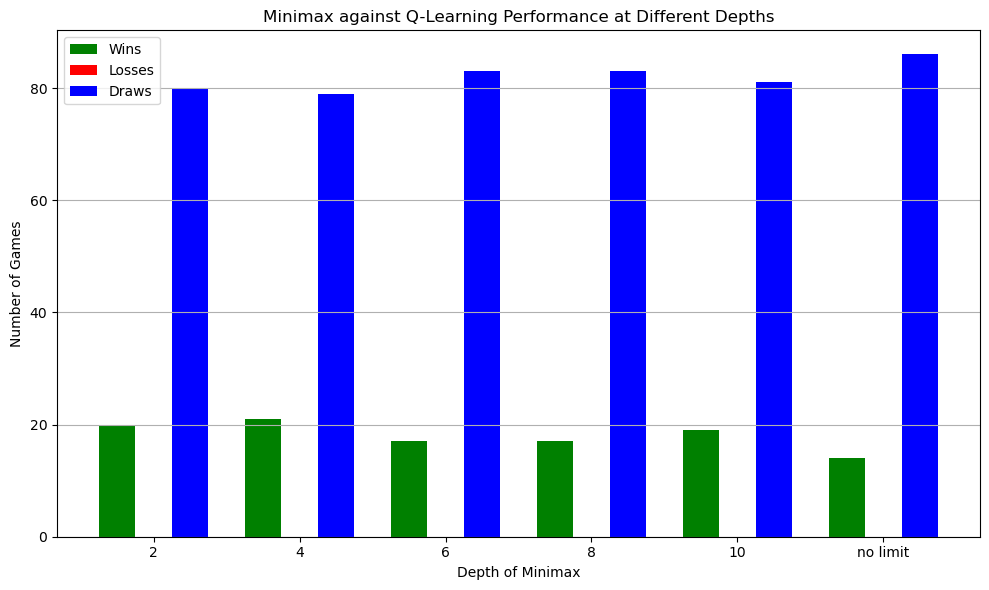

In [42]:
rst_mini_o = {}
for game in games:
    X_win = 0
    O_win = 0
    draws = 0
    
    start_time = time.time()
    
    for i in range(100):
        winner = None
        X_play = True
        while not winner:
            if X_play:
                board.add_move_q(q_agent_x, q_agent_o)
                winner = board.check_winner()
                X_play = False
                if winner:
                    break
            else:
                board.add_move_minimax(minimax_method, game.is_alpha_beta_pruning(), True)
                winner = board.check_winner()
                X_play = True
                if winner:
                    break
        
        if winner == 'X':
            X_win = X_win + 1
        elif winner == 'O':
            O_win = O_win + 1
        else:
            draws = draws + 1
        game.reset_game()

    end_time = time.time()

    depth = game.depth if game.is_limit_depth() else 'no limit'
    rst_mini_o[str(depth)] = [O_win, X_win, draws]
    print(f'test result: win times of minimax agent {depth} depth and {q_agent_x.episodes} episodes q-learning agent are {O_win} : {X_win}, the time is {end_time-start_time}s')

plot_mini_q(rst_mini_o)

#### Minimax + Alpha Beta Pruning Agent with Different Depth plays against q learning agent

In [213]:
board = TicTacToeBoard()

depths = [2, 4, 6, 8, 10]
games = [Game(board, depth, 2, True) for depth in depths]
games.append(Game(board, 0, 2, False))

minimax_method = Minimax(board, game)

q_agent_x = QLearningAgent('X', 100000)
q_agent_o = QLearningAgent('O', 100000)

Loaded Q-table: qtable_100000_X.pkl
Loaded Q-table: qtable_100000_O.pkl


##### Alpha beta pruning is X, Q-learning is O

test result: win times of minimax agent 2 depth against 100000 episodes q-learning agent are 78 : 0, the time is 2.8516149520874023s
test result: win times of minimax agent 4 depth against 100000 episodes q-learning agent are 75 : 0, the time is 2.592820644378662s
test result: win times of minimax agent 6 depth against 100000 episodes q-learning agent are 76 : 0, the time is 2.6755402088165283s
test result: win times of minimax agent 8 depth against 100000 episodes q-learning agent are 79 : 0, the time is 2.702789068222046s
test result: win times of minimax agent 10 depth against 100000 episodes q-learning agent are 74 : 0, the time is 2.7683768272399902s
test result: win times of minimax agent no limit depth against 100000 episodes q-learning agent are 78 : 0, the time is 3.0152695178985596s


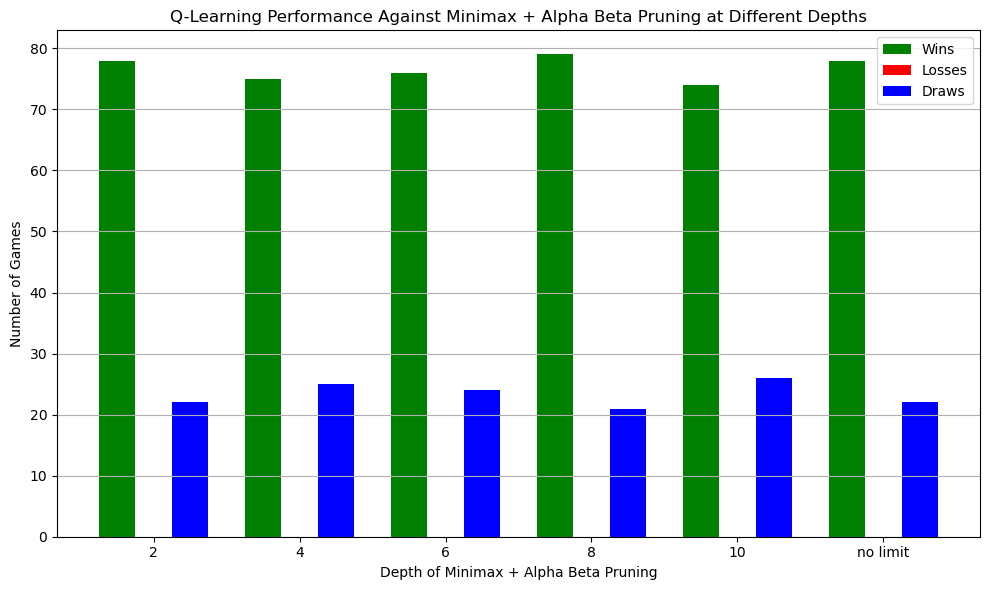

In [223]:
rst_mini_x = {}
for game in games:
    X_win = 0
    O_win = 0
    draws = 0
    
    start_time = time.time()
    
    for i in range(100):
        winner = None
        X_play = True
        while not winner:
            if X_play:
                board.add_move_minimax(minimax_method, game.is_alpha_beta_pruning(), False)
                winner = board.check_winner()
                X_play = False
                if winner:
                    break
            else:
                board.add_move_q(q_agent_x, q_agent_o)
                winner = board.check_winner()
                X_play = True
                if winner:
                    break
        
        if winner == 'X':
            X_win = X_win + 1
        elif winner == 'O':
            O_win = O_win + 1
        else:
            draws = draws + 1
        game.reset_game()

    end_time = time.time()

    depth = game.depth if game.is_limit_depth() else 'no limit'
    rst_mini_x[str(depth)] = [X_win, O_win, draws]
    print(f'test result: win times of minimax agent {depth} depth against {q_agent_o.episodes} episodes q-learning agent are {X_win} : {O_win}, the time is {end_time-start_time}s')

def plot_mini_q(rst):
    # Prepare data for plotting
    depths = list(rst.keys())
    results = np.array(list(rst.values()))
    
    wins = results[:, 0]
    losses = results[:, 1]
    draws = results[:, 2]
    
    # Create a custom x-axis for uniform spacing
    x_positions = np.arange(len(depths))
    
    # Set the width of the bars
    bar_width = 0.25
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plotting the bars
    plt.bar(x_positions - bar_width, wins, width=bar_width, label='Wins', color='green')
    plt.bar(x_positions, losses, width=bar_width, label='Losses', color='red')
    plt.bar(x_positions + bar_width, draws, width=bar_width, label='Draws', color='blue')
    
    # Adding titles and labels
    plt.title('Minimax + Alpha Beta Pruning against Q-Learning Performance at Different Depths')
    plt.xlabel('Depth of Minimax + Alpha Beta Pruning')
    plt.ylabel('Number of Games')
    plt.xticks(x_positions, depths)
    plt.legend()
    plt.grid(axis='y')
    
    # Show plot
    plt.tight_layout()
    plt.show()
    
plot_mini_q(rst_mini_x)

##### Q-learning is X, alpha beta pruning is O

test result: win times of 100000 episodes q-learning agent minimax agent 2 depth are 0 : 19, the time is 13.135639905929565s
test result: win times of 100000 episodes q-learning agent minimax agent 4 depth are 0 : 21, the time is 12.923762798309326s
test result: win times of 100000 episodes q-learning agent minimax agent 6 depth are 0 : 25, the time is 13.356059074401855s
test result: win times of 100000 episodes q-learning agent minimax agent 8 depth are 0 : 26, the time is 12.150523662567139s
test result: win times of 100000 episodes q-learning agent minimax agent 10 depth are 0 : 19, the time is 13.054839372634888s
test result: win times of 100000 episodes q-learning agent minimax agent no limit depth are 0 : 19, the time is 14.103070735931396s


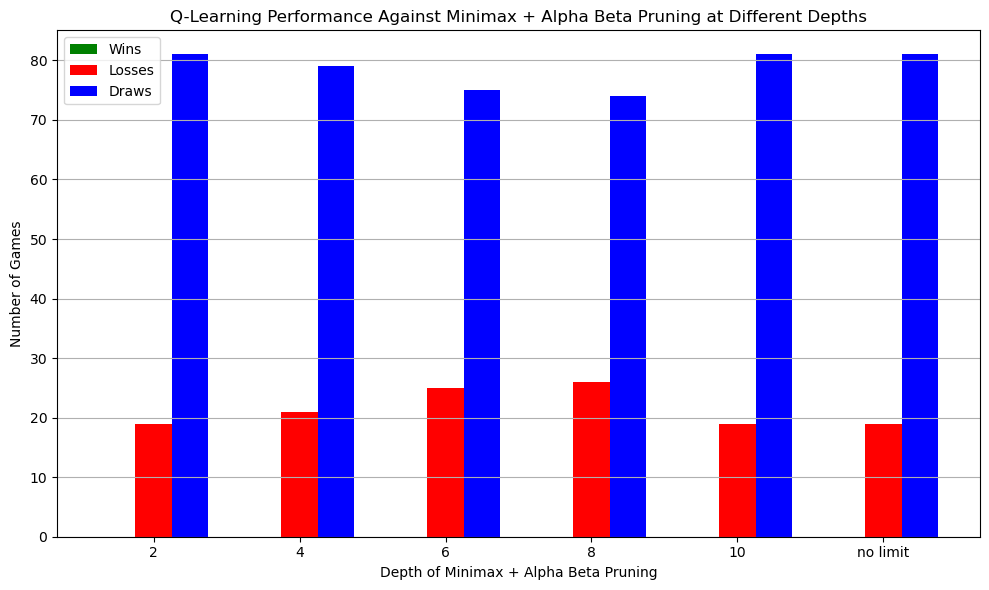

In [221]:
rst_mini_o = {}
for game in games:
    X_win = 0
    O_win = 0
    draws = 0
    
    start_time = time.time()
    
    for i in range(100):
        winner = None
        X_play = True
        while not winner:
            if X_play:
                board.add_move_q(q_agent_x, q_agent_o)
                winner = board.check_winner()
                X_play = False
                if winner:
                    break
            else:
                board.add_move_minimax(minimax_method, game.is_alpha_beta_pruning(), True)
                winner = board.check_winner()
                X_play = True
                if winner:
                    break
        
        if winner == 'X':
            X_win = X_win + 1
        elif winner == 'O':
            O_win = O_win + 1
        else:
            draws = draws + 1
        game.reset_game()

    end_time = time.time()

    depth = game.depth if game.is_limit_depth() else 'no limit'
    rst_mini_o[str(depth)] = [O_win, X_win, draws]
    print(f'test result: win times of minimax agent {depth} depth and {q_agent_x.episodes} episodes q-learning agent are {O_win} : {X_win}, the time is {end_time-start_time}s')

plot_mini_q(rst_mini_o)

#### Minimax + alpha beta pruning (no depth limit) plays against Minimax (no delth limit), run 100 times

In [227]:
board = TicTacToeBoard()
game_mini = Game(board, 0, 1, False)
game_ab = Game(board, 0, 2, False)
minimax_method = Minimax(board, game)

##### Minimax is X, Minimax + alpha beta pruning is O 

In [241]:
rst_mini_alpha = {}

X_win = 0
O_win = 0
draws = 0

start_time = time.time()

for i in range(100):
    winner = None
    X_play = True
    while not winner:
        if X_play:
            board.add_move_minimax(minimax_method, game_mini.is_alpha_beta_pruning(), False)
            winner = board.check_winner()
            X_play = False
            if winner:
                break
        else:
            board.add_move_minimax(minimax_method, game_ab.is_alpha_beta_pruning(), True)
            winner = board.check_winner()
            X_play = True
            if winner:
                break
    
    if winner == 'X':
        X_win = X_win + 1
    elif winner == 'O':
        O_win = O_win + 1
    else:
        draws = draws + 1
    game.reset_game()

end_time = time.time()

rst_mini_alpha['mini'] = [X_win, O_win, draws]
print(f'test result: win times of minimax agent against alpha beta pruning agent are {X_win} : {O_win}, the time is {end_time-start_time}s')

test result: win times of minimax agent against alpha beta pruning agent are 54 : 46, the time is 0.5364115238189697s


##### Minimax + alpha beta pruning is X, Minimax is O 

In [237]:
X_win = 0
O_win = 0
draws = 0

start_time = time.time()

for i in range(100):
    winner = None
    X_play = True
    while not winner:
        if X_play:
            board.add_move_minimax(minimax_method, game_ab.is_alpha_beta_pruning(), False)
            winner = board.check_winner()
            X_play = False
            if winner:
                break
        else:
            board.add_move_minimax(minimax_method, game_mini.is_alpha_beta_pruning(), True)
            winner = board.check_winner()
            X_play = True
            if winner:
                break
    
    if winner == 'X':
        X_win = X_win + 1
    elif winner == 'O':
        O_win = O_win + 1
    else:
        draws = draws + 1
    game.reset_game()

end_time = time.time()

rst_mini_alpha['ab'] = [O_win, X_win, draws]
print(f'test result: win times of minimax agent against alpha beta pruning agent are {O_win} : {X_win}, the time is {end_time-start_time}s')

test result: win times of minimax agent against alpha beta pruning agent are 40 : 60, the time is 0.5898995399475098s
